# Modelowanie
1. [Import bibliotek](#sekcja_intro)
2. [Wczytanie danych](#sekcja_wczytywanie)
3. [Zapoznanie się z danymi](#sekcja_rozpoznanie)
3. [Wizualizacja danych](#sekcja_wizualizacja)

    a. [Wykresy podstawowe](#wykresy_podstawowe)

    b. [Wykresy zaawansowane](#wykresy_zaawansowane)

    c. [Mapy](#mapy)

<a id="sekcja_intro"></a>
## 1. Import bibliotek

In [4]:
# Ładuje rozszerzenie autoreload, które pozwala na automatyczne przeładowywanie modułów
%load_ext autoreload

# Ustawia tryb autoreload na 2 - wszystkie importowane moduły będą automatycznie przeładowywane przy każdej zmianie
%autoreload 2

# Importy lokalne
from src.data.datareader import CleanedDataReader
from src.data.utils import create_group_id, dropna, drop_duplicates
from src.features.transformers import CapTransformer
from src.features.sampling import split_data_by_group_and_stratify, calculate_frequency
from src.models.scoring import model_summary
from src.models.modeling import train_and_evaluate_model
from src.data.plots import freq_over_attribute_plot

from sklearn.preprocessing import (
    FunctionTransformer,
    KBinsDiscretizer,
    OneHotEncoder,
    StandardScaler,
)

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import ShuffleSplit, cross_validate, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import svm, tree, linear_model, neighbors, ensemble
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, classification_report
from sklearn import metrics
from sklearn.linear_model import PoissonRegressor
from sklearn.dummy import DummyRegressor

import numpy as np
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_poisson_deviance

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a id="sekcja_wczytywanie"></a>
## 2. Wczytywanie danych

In [5]:
data_reader = CleanedDataReader(path='../../data/raw/claims_data.csv')
df = data_reader.get_enhanced_data(index_col=0)

Bad line:
['653', '1357.0', '1.0', '0.01', 'E', '7.0', '0.0', '41.0', '80.0', 'B12', 'Diesel', '6257.0', 'R93', '']
was converted to:
['653', '1357.0', '1.0', '0.01', 'E', '7.0', '0.0', '41.0', '80.0', 'B12', 'Diesel', '6257.0', 'R93']

Bad line:
['1435', '2967.0', '1.0', '0.64', 'B', '5.0', '0.0', '53.0', '50.0', 'B12', '', 'Regular', '68.0', 'R52']
was converted to:
['1435', '2967.0', '1.0', '0.64', 'B', '5.0', '0.0', '53.0', '50.0', 'B12', 'Regular', '68.0', 'R52']

Bad line:
['123123', '1070775.0', '0.0', '0.48', 'B', '8.0', '7.0', '42.0', '59.0', 'B2', 'Diesel', '72.0', 'R52', '']
was converted to:
['123123', '1070775.0', '0.0', '0.48', 'B', '8.0', '7.0', '42.0', '59.0', 'B2', 'Diesel', '72.0', 'R52']

Bad line:
['381011', '3043346.0', '0.0', '0.92', 'A', '4.0', '2.0', '60.0', '90.0', 'B12', '', 'Regular', '6.0', 'R72']
was converted to:
['381011', '3043346.0', '0.0', '0.92', 'A', '4.0', '2.0', '60.0', '90.0', 'B12', 'Regular', '6.0', 'R72']

Bad line:
['547534', '4138712.0', '1.0

## 3. Przygotowanie danych

Pierwsze, bardzo ogólne przetworzenie danych:
1. Usunięcie tych rekordów, które mają `NULL` w kolumnach `ClaimNb` lub `Exposure`,
2. Usunięcie duplikatów (jeżeli takie są) po kolumnie `IDPol`
3. Dodanie kolumny identyfikującej grupy polis z takimi samymi wartościami atrybutów - zadbamy o to, aby w momencie losowania zbiorów `train` i `test` polisy w ramach jednej grupy w całości znaleźli się w jednym ze zbiorów - ograniczymy w ten sposób ryzyko `Data Leakage`.

In [6]:


df = dropna(df, subset=['ClaimNb', 'Exposure'])
df = drop_duplicates(df, subset=['IDpol'])
df = create_group_id(df)

### Pipelines

In [7]:
numerical_features = ['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density']
categorical_features = [col for col in df.select_dtypes(exclude='number').columns.tolist() if col not in numerical_features]

print(f"All columns: {df.columns.tolist()}")
print(f"Numerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")

numeric_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

transformer_features = ColumnTransformer(transformers=[
    ("binned_numeric_drivage", KBinsDiscretizer(n_bins=20, random_state=0), ["DrivAge"]),
    ("binned_numeric_vehage", KBinsDiscretizer(n_bins=8, random_state=0), ["VehAge"]),
    ('number', numeric_pipeline, numerical_features),
    ('category', categorical_pipeline, categorical_features)
],
remainder='drop',
force_int_remainder_cols=False,
verbose_feature_names_out=False
)

pipeline_features = Pipeline([
    ('cap_veh_power', CapTransformer(column='VehPower', cap_value=13, else_behaviour='identity')),
    ('cap_veh_age', CapTransformer(column='VehAge', cap_value=21, else_behaviour='identity')),
    ('cap_driv_age', CapTransformer(column='DrivAge', cap_value=90, else_behaviour='identity')),
    ('cap_bonus_malus', CapTransformer(column='BonusMalus', cap_value=100, else_behaviour='int')),
    ('cap_density', CapTransformer(column='Density', cap_value=100_000, else_behaviour='log')),
    ('transformer', transformer_features),
])

pipeline_features.fit(df)

All columns: ['IDpol', 'ClaimNb', 'Exposure', 'Area', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'VehBrand', 'VehGas', 'Density', 'Region', 'GroupID']
Numerical features: ['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density']
Categorical features: ['Area', 'VehBrand', 'VehGas', 'Region']


Pipeline(steps=[('cap_veh_power',
                 CapTransformer(cap_value=13, column='VehPower',
                                else_behaviour='identity')),
                ('cap_veh_age',
                 CapTransformer(cap_value=21, column='VehAge',
                                else_behaviour='identity')),
                ('cap_driv_age',
                 CapTransformer(cap_value=90, column='DrivAge',
                                else_behaviour='identity')),
                ('cap_bonus_malus',
                 CapTransformer(cap_value=100, column='BonusMalus'...
                                                  ['VehAge']),
                                                 ('number',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['VehPower', 'VehAge',
                                                   'DrivAge', 'BonusMalus',
                                                   'Density']),
                                                 ('category',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Area', 'VehBrand', 'VehGas',
                                                   'Region'])],
                                   verbose_feature_names_out=False))])

### Atrybuty po zaaplikowaniu pipelinów

In [8]:
pipeline_features[-1].get_feature_names_out()

array(['DrivAge_0.0', 'DrivAge_1.0', 'DrivAge_2.0', 'DrivAge_3.0',
       'DrivAge_4.0', 'DrivAge_5.0', 'DrivAge_6.0', 'DrivAge_7.0',
       'DrivAge_8.0', 'DrivAge_9.0', 'DrivAge_10.0', 'DrivAge_11.0',
       'DrivAge_12.0', 'DrivAge_13.0', 'DrivAge_14.0', 'DrivAge_15.0',
       'DrivAge_16.0', 'DrivAge_17.0', 'DrivAge_18.0', 'DrivAge_19.0',
       'VehAge_0.0', 'VehAge_1.0', 'VehAge_2.0', 'VehAge_3.0',
       'VehAge_4.0', 'VehAge_5.0', 'VehAge_6.0', 'VehAge_7.0', 'VehPower',
       'VehAge', 'DrivAge', 'BonusMalus', 'Density', 'Area_A', 'Area_B',
       'Area_C', 'Area_D', 'Area_E', 'Area_F', 'VehBrand_B1',
       'VehBrand_B10', 'VehBrand_B11', 'VehBrand_B12', 'VehBrand_B13',
       'VehBrand_B14', 'VehBrand_B2', 'VehBrand_B3', 'VehBrand_B4',
       'VehBrand_B5', 'VehBrand_B6', 'VehGas_Diesel', 'VehGas_Regular',
       'Region_R11', 'Region_R21', 'Region_R22', 'Region_R23',
       'Region_R24', 'Region_R25', 'Region_R26', 'Region_R31',
       'Region_R41', 'Region_R42', 'Region_R4

### Podział zbioru na train i test
Podział jest dokonany tak aby:
1. Rekordy, które mają tę samą `GroupID` byli w tym samym zbiorze (treningowy lub testowy) - `GroupShuffleSplit `
2. Zapewnić aby kolumna `ClaimNb` miała takie same proporcje w zbiorze train i test - `StratifiedShuffleSplit` 

In [9]:
train, test = split_data_by_group_and_stratify(df)

Train frequency: 10.053%
Test frequency: 10.137%
Train-test frequency difference: 0.083% (Relative difference: 0.829%)


# Modelowanie

Uzasadnienie wyboru:
- Rozkład Poissona: Naturalny wybór dla danych liczbowych o niskiej częstości występowania zdarzeń
- Ekspozycja jako waga: Pozwala uwzględnić różny czas obserwacji polis
- Funkcja straty: Poisson deviance - właściwa metryka dla danych liczbowych z rozkładem Poissona
- Walidacja temporalna: Uwzględnia czasową naturę danych ubezpieczeniowych

### Pierwsze podejście do wytrenowania modelu

In [72]:
model_class = PoissonRegressor
params = {
    'alpha':0.0001,
    'solver':'newton-cholesky'
}

model, (summary, X_train_pred, X_test_pred) = train_and_evaluate_model(train, test, pipeline_features, model_class, params)

In [75]:
for key, value in summary.items():
    if 'Improvement' in key or 'Frequency' in key:
        print(f"{key}: {value:.3f}%")
    else:
        print(f"{key}: {value:.3f}")

Poisson Deviance Dummy Train: 62.403
Poisson Deviance Dummy Test: 63.472
Poisson Deviance Train: 59.279
Poisson Deviance Test: 60.459
Improvement in Deviance Train: 5.005%
Improvement in Deviance Test: 4.747%
Frequency Train Actual: 10.053%
Frequency Train Model: 10.057%
Frequency Test Actual: 10.137%
Frequency Test Model: 10.022%


(<Figure size 1500x800 with 2 Axes>,
 <Axes: title={'center': 'Comparison to prediction frequency'}, xlabel='DrivAge', ylabel='Exposure'>,
 <Axes: xlabel='Rank', ylabel='Frequency'>)

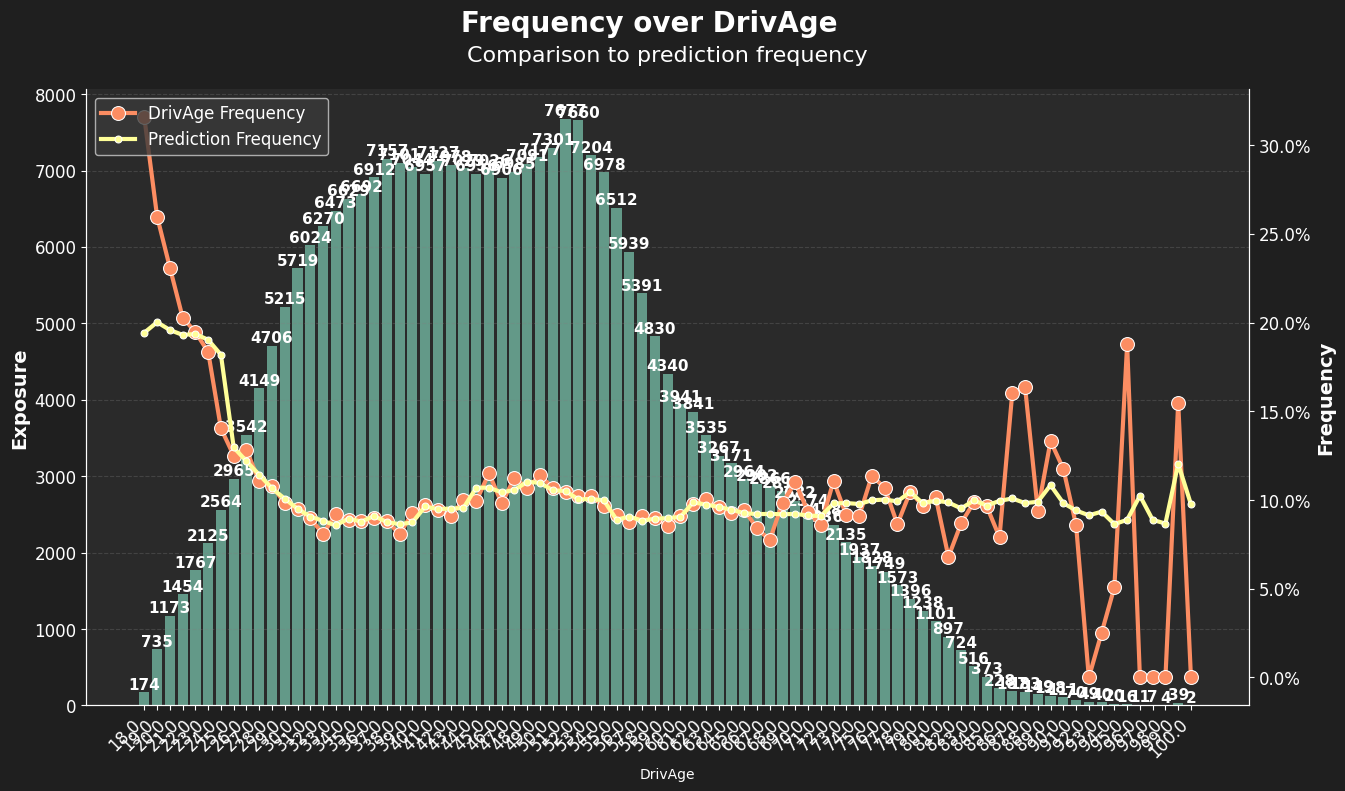

In [11]:
freq_over_attribute_plot(X_train_pred, attribute='DrivAge', compare_to='prediction')

(<Figure size 1500x800 with 2 Axes>,
 <Axes: title={'center': 'Comparison to prediction frequency'}, xlabel='DrivAge', ylabel='Exposure'>,
 <Axes: xlabel='Rank', ylabel='Frequency'>)

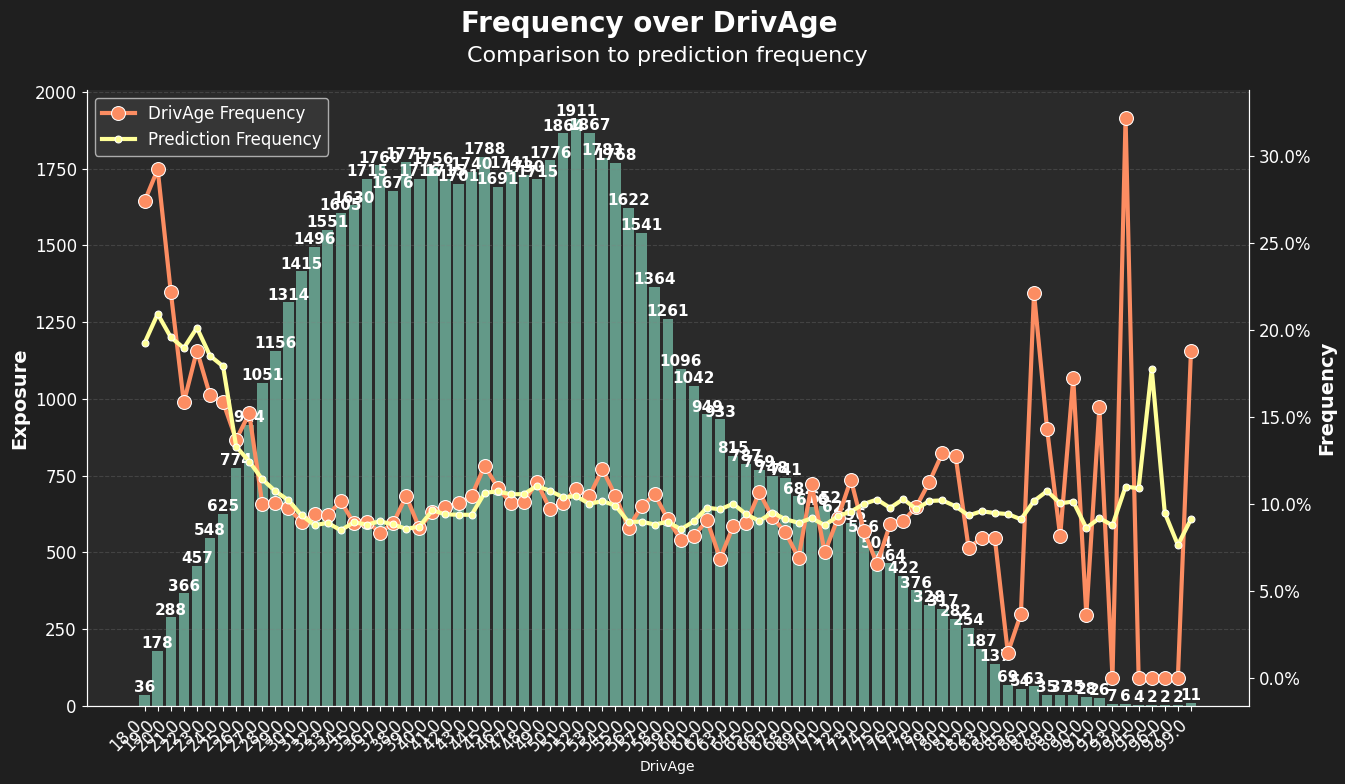

In [12]:
freq_over_attribute_plot(X_test_pred, attribute='DrivAge', compare_to='prediction')

In [13]:
lista_train = []
lista_test = []
for alpha in [1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001]:
    model_class = PoissonRegressor
    params = {
        'solver':'newton-cholesky'
    }
 
    params['alpha'] = alpha
    model, (summary, X_train_pred, X_test_pred) = train_and_evaluate_model(train, test, pipeline_features, model_class, params, verbose=False)
    lista_train.append(summary['Improvement in Deviance Train'])
    lista_test.append(summary['Improvement in Deviance Test'])


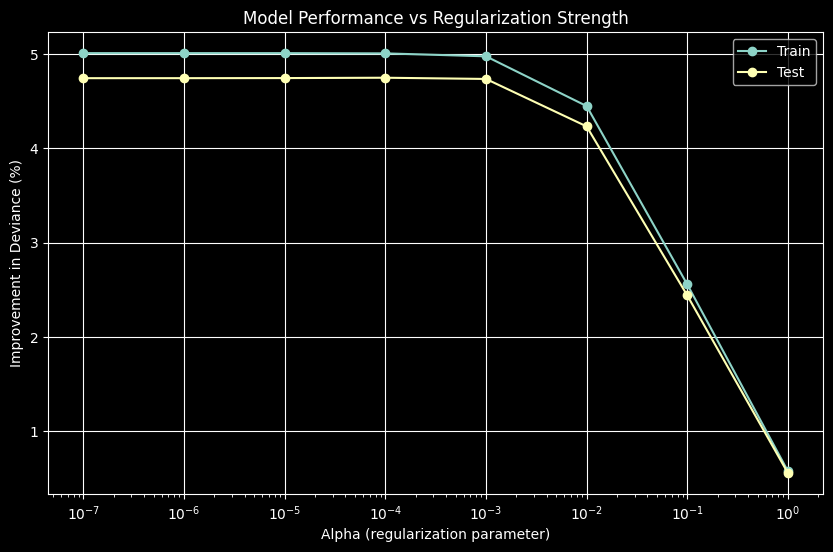

In [14]:
import matplotlib.pyplot as plt

alphas = [1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001]
plt.figure(figsize=(10, 6))
plt.plot(alphas, lista_train, 'o-', label='Train')
plt.plot(alphas, lista_test, 'o-', label='Test')
plt.xscale('log')
plt.xlabel('Alpha (regularization parameter)')
plt.ylabel('Improvement in Deviance (%)')
plt.title('Model Performance vs Regularization Strength')
plt.legend()
plt.grid(True)
plt.show()

In [83]:
X_train = train[['Area', 'VehPower', 'VehAge', 'DrivAge','BonusMalus','VehBrand','VehGas','Density','Region']]
y_train = train['ClaimNb']
weights_train = train['Exposure']
y_freq_train = y_train / weights_train

X_test = test[['Area', 'VehPower', 'VehAge', 'DrivAge','BonusMalus','VehBrand','VehGas','Density','Region']]
y_test = test['ClaimNb']
weights_test = test['Exposure']
y_freq_test = y_test / weights_test

import numpy as np
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_poisson_deviance

space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.3)),
    'max_depth': hp.quniform('max_depth', 3, 9, 1),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'min_child_weight': hp.loguniform('min_child_weight', np.log(1), np.log(100)),
    'gamma': hp.loguniform('gamma', np.log(0.01), np.log(10)),
    'alpha': hp.loguniform('alpha', np.log(0.01), np.log(10)),
    'lambda': hp.loguniform('lambda', np.log(0.01), np.log(10)),
    'n_estimators': hp.quniform('n_estimators', 5000, 30000, 1000),
    'early_stopping_rounds': hp.quniform('early_stopping_rounds', 10, 30, 1)
}

def objective(params):
    # Konwersja parametrów do wymaganych typów
    params = {
        'objective': 'count:poisson',
        'eval_metric': 'poisson-nloglik',
        'learning_rate': float(params['learning_rate']),
        'max_depth': int(params['max_depth']),
        'subsample': float(params['subsample']),
        'colsample_bytree': float(params['colsample_bytree']),
        'min_child_weight': float(params['min_child_weight']),
        'gamma': float(params['gamma']),
        'reg_alpha': float(params['alpha']),
        'reg_lambda': float(params['lambda']),
        'tree_method': 'hist',
        'enable_categorical': True,
        'n_estimators': int(params['n_estimators']),
        'early_stopping_rounds': int(params['early_stopping_rounds'])
    }

    # Pipeline z preprocessorem i modelem
    model = Pipeline([
        ('preporcessor', pipeline_features),
        ('regressor', xgb.XGBRegressor(**params))
    ])

    # Temporalna walidacja krzyżowa
    tscv = TimeSeriesSplit(n_splits=4)
    scores = []

    for train_idx, val_idx in tscv.split(X_train):
        # Używamy .loc zamiast .iloc aby uniknąć błędu out-of-bounds
        X_train_cv = X_train.loc[X_train.index[train_idx]]
        X_val_cv = X_train.loc[X_train.index[val_idx]]
        
        y_train_cv = y_freq_train.loc[y_freq_train.index[train_idx]]
        y_val_cv = y_freq_train.loc[y_freq_train.index[val_idx]]
        
        weights_train_cv = weights_train.loc[train.index[train_idx]]
        weights_val_cv = weights_train.loc[train.index[val_idx]]

        model.fit(
            X_train_cv, y_train_cv,
            regressor__sample_weight=weights_train_cv,
            regressor__eval_set=[(pipeline_features.transform(X_val_cv), y_val_cv)],
            regressor__verbose=False
        )

        # Predykcja z uwzględnieniem ekspozycji
        pred = model.predict(X_val_cv)
        score = mean_poisson_deviance(y_val_cv, pred, sample_weight=weights_val_cv)
        scores.append(score)

    return {'loss': np.mean(scores), 'status': STATUS_OK}

# Optymalizacja
trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=5,
    trials=trials,
    rstate=np.random.default_rng(42)
)

100%|██████████| 5/5 [01:02<00:00, 12.49s/trial, best loss: 0.31463238993756476]


In [101]:
# ----------------------------------------------------------
# 4. Trening finalnego modelu
# ----------------------------------------------------------

# Najlepsze parametry
best_params = {
    'objective': 'count:poisson',
    'eval_metric': ['poisson-nloglik', 'rmse'],
    'learning_rate': best['learning_rate'],
    'max_depth': int(best['max_depth']),
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree'],
    'min_child_weight': best['min_child_weight'],
    'gamma': best['gamma'],
    'reg_alpha': best['alpha'],
    'reg_lambda': best['lambda'],
    'tree_method': 'hist',
    'enable_categorical': True,
    'n_estimators': int(best['n_estimators']),
    # 'early_stopping_rounds': int(best['early_stopping_rounds'])
}
# Finalny pipeline
final_model = Pipeline([
    ('preprocessor', pipeline_features),
    ('regressor', xgb.XGBRegressor(**best_params))
])

# Trening na pełnych danych
final_model.fit(
    X_train, y_freq_train,
    regressor__sample_weight=weights_train,
    regressor__eval_set=[(pipeline_features.transform(X_test), y_freq_test)],
    # regressor__early_stopping_rounds=best_params['early_stopping_rounds'],
    regressor__verbose=10
)

[0]	validation_0-poisson-nloglik:1.43155	validation_0-rmse:5.00716
[10]	validation_0-poisson-nloglik:1.34669	validation_0-rmse:5.00429
[20]	validation_0-poisson-nloglik:1.30524	validation_0-rmse:5.00127
[30]	validation_0-poisson-nloglik:1.28817	validation_0-rmse:4.99936
[40]	validation_0-poisson-nloglik:1.28092	validation_0-rmse:4.99840
[50]	validation_0-poisson-nloglik:1.27748	validation_0-rmse:4.99795
[60]	validation_0-poisson-nloglik:1.27565	validation_0-rmse:4.99770
[70]	validation_0-poisson-nloglik:1.27489	validation_0-rmse:4.99758
[80]	validation_0-poisson-nloglik:1.27409	validation_0-rmse:4.99748
[90]	validation_0-poisson-nloglik:1.27313	validation_0-rmse:4.99736
[100]	validation_0-poisson-nloglik:1.27273	validation_0-rmse:4.99732
[110]	validation_0-poisson-nloglik:1.27254	validation_0-rmse:4.99730
[120]	validation_0-poisson-nloglik:1.27268	validation_0-rmse:4.99731
[130]	validation_0-poisson-nloglik:1.27282	validation_0-rmse:4.99732
[140]	validation_0-poisson-nloglik:1.27265	va

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('cap_veh_power',
                                  CapTransformer(cap_value=13,
                                                 column='VehPower',
                                                 else_behaviour='identity')),
                                 ('cap_veh_age',
                                  CapTransformer(cap_value=21, column='VehAge',
                                                 else_behaviour='identity')),
                                 ('cap_driv_age',
                                  CapTransformer(cap_value=90, column='DrivAge',
                                                 else_behaviour='identity')),
                                 ('cap_bonus_malus',
                                  CapTransformer(c...
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              learning_rate=np.float64(0.13621251311224802),
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=7, max_leaves=None,
                              min_child_weight=np.float64(58.59401406052271),
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=21000,
                              n_jobs=None, num_parallel_tree=None, ...))])

In [107]:
best_params

{'objective': 'count:poisson',
 'eval_metric': ['poisson-nloglik', 'rmse'],
 'learning_rate': np.float64(0.13621251311224802),
 'max_depth': 7,
 'subsample': np.float64(0.9254621630561151),
 'colsample_bytree': np.float64(0.7936739623353964),
 'min_child_weight': np.float64(58.59401406052271),
 'gamma': np.float64(1.4017655333671677),
 'reg_alpha': np.float64(9.325054944915186),
 'reg_lambda': np.float64(0.02194768920015761),
 'tree_method': 'hist',
 'enable_categorical': True,
 'n_estimators': 21000}

In [102]:
summary, X_train_pred, X_test_pred = model_summary(final_model, train, y_train, test, y_test, weights_train, weights_test)

(<Figure size 1500x800 with 2 Axes>,
 <Axes: title={'center': 'Comparison to prediction frequency'}, xlabel='DrivAge', ylabel='Exposure'>,
 <Axes: xlabel='Rank', ylabel='Frequency'>)

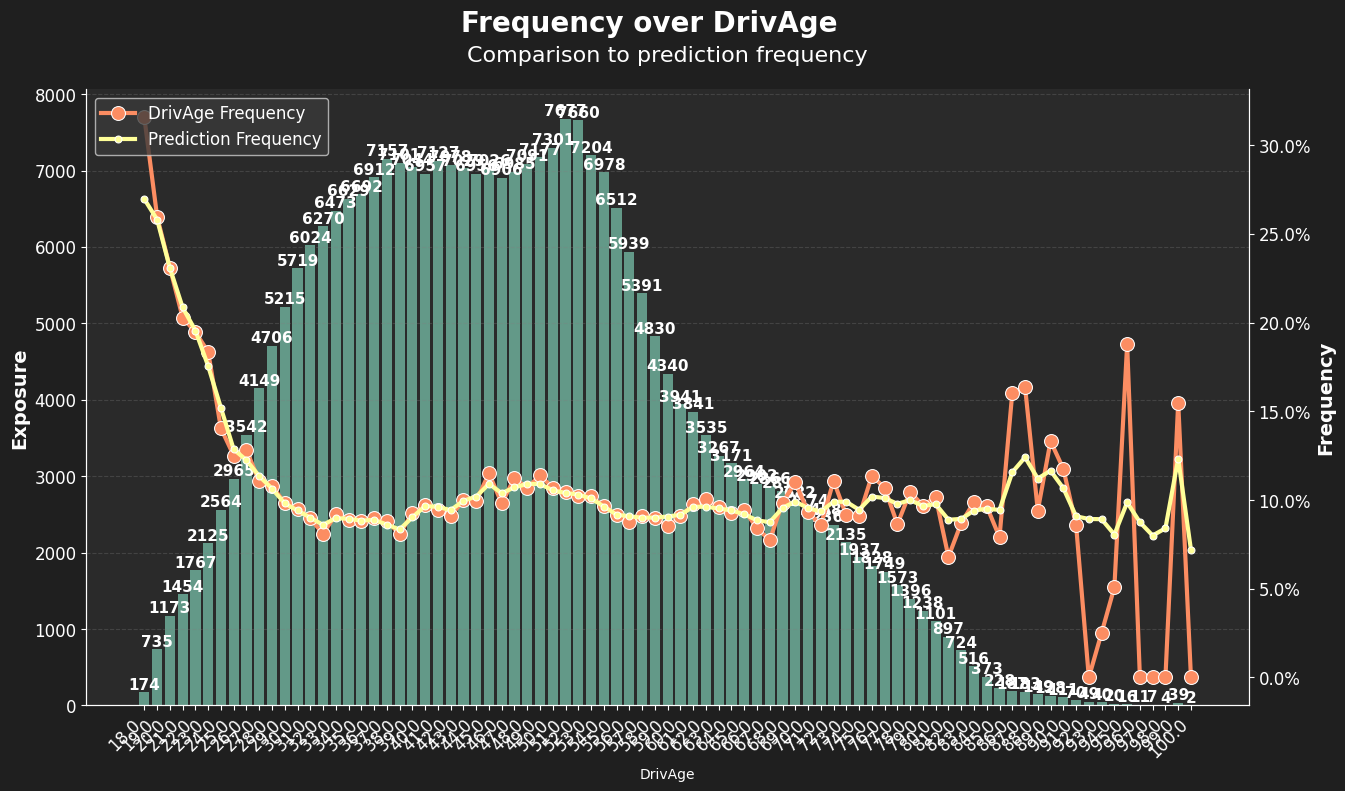

In [106]:
freq_over_attribute_plot(X_train_pred, attribute='DrivAge', compare_to='prediction')

In [104]:
for key, value in summary.items():
    if 'Improvement' in key or 'Frequency' in key:
        print(f"{key}: {value:.3f}%")
    else:
        print(f"{key}: {value:.3f}")

Poisson Deviance Dummy Train: 36.417
Poisson Deviance Dummy Test: 36.566
Poisson Deviance Train: 35.571
Poisson Deviance Test: 36.366
Improvement in Deviance Train: 2.324%
Improvement in Deviance Test: 0.547%
Frequency Train Actual: 10.053%
Frequency Train Model: 10.057%
Frequency Test Actual: 10.137%
Frequency Test Model: 10.065%


In [52]:
new_train = train.copy()
new_train['y_pred'] = final_model.predict(train)

In [53]:
new_train

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,GroupID,y_pred
0,1.0,1.0,0.100000,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,1.0,0.211788
1,3.0,1.0,0.770000,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,1.0,0.211788
2,5.0,1.0,0.750000,B,6.0,2.0,52.0,50.0,B12,Diesel,54.0,R22,2.0,0.041378
4,11.0,1.0,0.840000,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72,4.0,0.093505
5,13.0,1.0,0.520000,E,6.0,2.0,38.0,50.0,B12,Regular,3003.0,R31,5.0,0.051120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678002,6114322.0,0.0,0.005479,E,11.0,0.0,49.0,74.0,B12,Diesel,5360.0,R11,528758.0,0.107010
678003,6114323.0,0.0,0.005479,D,4.0,0.0,34.0,80.0,B12,Regular,731.0,R82,528759.0,0.176184
678004,6114324.0,0.0,0.005479,D,11.0,0.0,41.0,50.0,B12,Diesel,528.0,R93,528760.0,0.058204
678006,6114326.0,0.0,0.002740,E,4.0,0.0,54.0,50.0,B12,Regular,3317.0,R93,528762.0,0.142401


(<Figure size 1500x800 with 2 Axes>,
 <Axes: title={'center': 'Comparison to prediction frequency'}, xlabel='DrivAge', ylabel='Exposure'>,
 <Axes: xlabel='Rank', ylabel='Frequency'>)

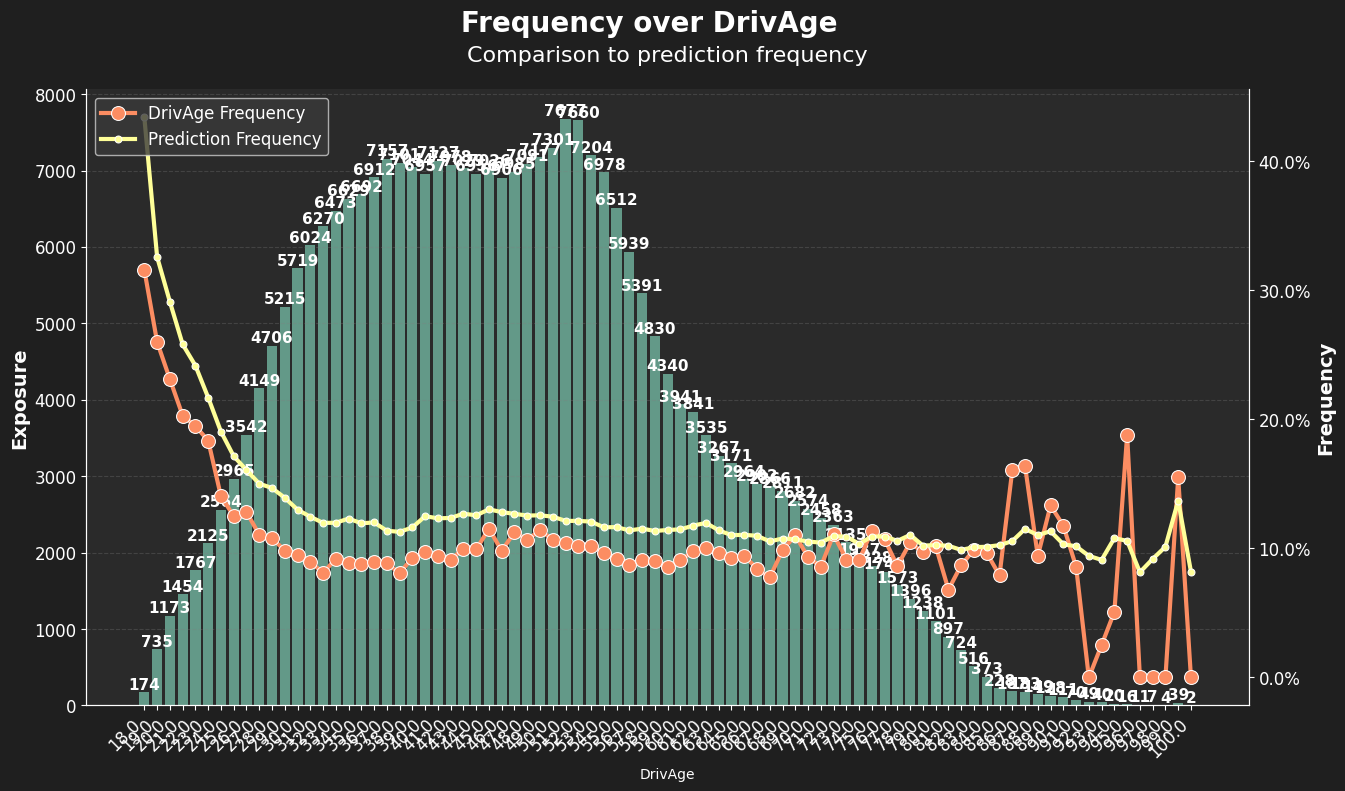

In [54]:
freq_over_attribute_plot(new_train, attribute='DrivAge', compare_to='prediction')

In [61]:
new_train = train.copy()
new_train['y_pred'] = final_model.predict(train)
new_train.groupby('DrivAge')[['y_pred', 'ClaimNb']].sum().head(20)

,y_pred,ClaimNb
DrivAge,,
18.0,75.573387,55.0
19.0,239.451874,191.0
20.0,341.362091,271.0
21.0,375.166077,295.0
22.0,426.782257,344.0
23.0,460.817474,390.0
24.0,488.330658,360.0
25.0,508.421112,371.0
26.0,569.072449,454.0


In [89]:
model_class = XGBRegressor
# params = {
#     'seed':0,
#     'n_estimators':1000,
#     'objective':'count:poisson',
#     'eval_metric':'poisson-nloglik',
#     'learning_rate':0.01,
#     'max_depth':6,
#     'subsample':0.8,
#     'colsample_bytree':0.8,
#     'min_child_weight':1,
#     'gamma':0.1,
# }
params = best_params
params['early_stopping_rounds'] = None

model, (summary, X_train_pred, X_test_pred) = train_and_evaluate_model(train, test, pipeline_features, model_class, params)

(<Figure size 1500x800 with 2 Axes>,
 <Axes: title={'center': 'Comparison to prediction frequency'}, xlabel='DrivAge', ylabel='Exposure'>,
 <Axes: xlabel='Rank', ylabel='Frequency'>)

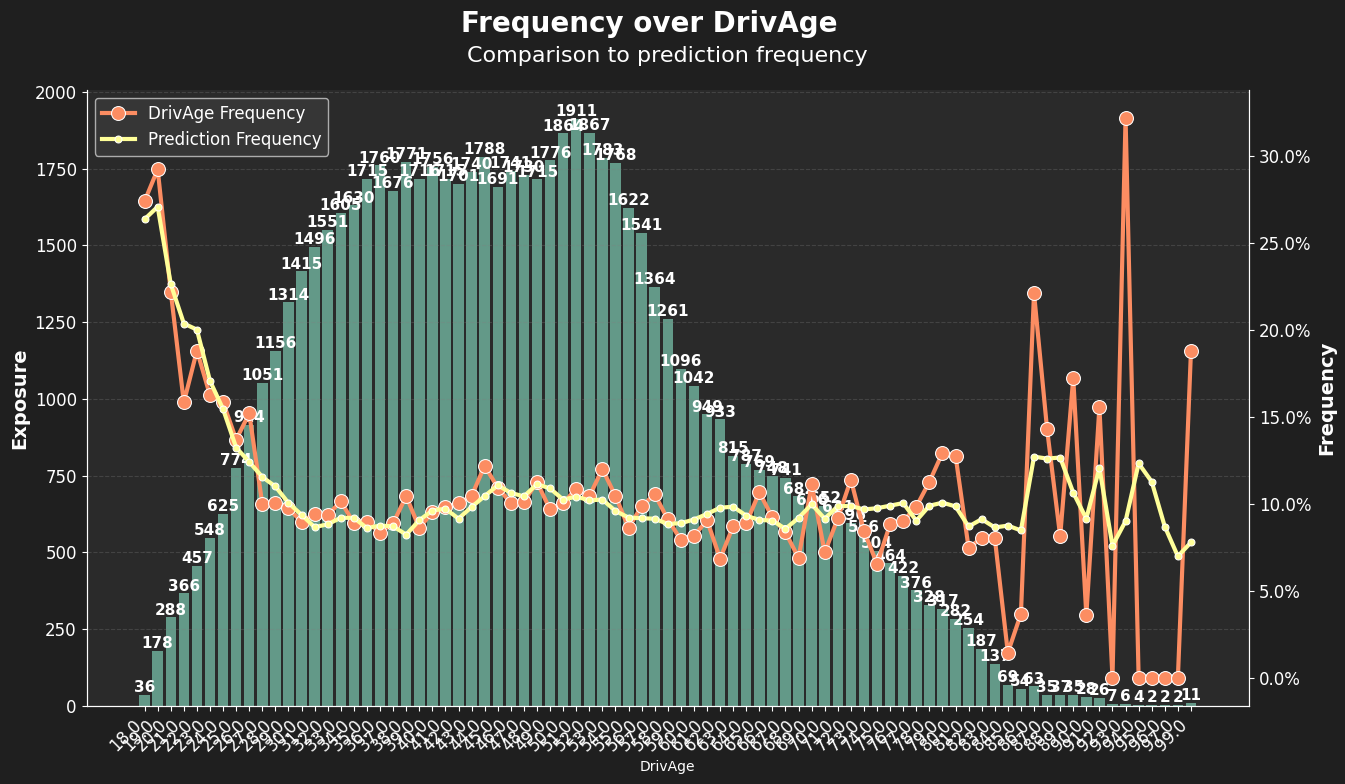

In [90]:
freq_over_attribute_plot(X_test_pred, attribute='DrivAge', compare_to='prediction')

In [91]:
for key, value in summary.items():
    if 'Improvement' in key or 'Frequency' in key:
        print(f"{key}: {value:.3f}%")
    else:
        print(f"{key}: {value:.3f}")

Poisson Deviance Dummy Train: 62.403
Poisson Deviance Dummy Test: 63.472
Poisson Deviance Train: 56.229
Poisson Deviance Test: 58.257
Improvement in Deviance Train: 9.892%
Improvement in Deviance Test: 8.217%
Frequency Train Actual: 10.053%
Frequency Train Model: 10.057%
Frequency Test Actual: 10.137%
Frequency Test Model: 10.065%


In [92]:
new_train = train.copy()
new_train['y_pred'] = model.predict(train) * new_train['Exposure']
new_train.groupby('DrivAge')[['y_pred', 'ClaimNb']].sum().head(20)

,y_pred,ClaimNb
DrivAge,,
18.0,46.981668,55.0
19.0,189.757134,191.0
20.0,270.742069,271.0
21.0,303.236564,295.0
22.0,345.551189,344.0
23.0,372.992011,390.0
24.0,389.679535,360.0
25.0,381.238018,371.0
26.0,433.959205,454.0
